# Imports

In [40]:
import numpy as np
import pandas as pd
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Fetching data from imdb

In [41]:
def data_fetch():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

    word_index = tf.keras.datasets.imdb.get_word_index()
    index2word = dict((i + 3, word) for (word, i) in word_index.items())
    index2word[0] = '[pad]' #padding
    index2word[1] = '[bos]' #begin of sentence
    index2word[2] = '[oov]' # out of vocabulary
    x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
    x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])
    return x_train, y_train, x_test, y_test

# Vectorizing examples

In [42]:
def vectorize_examples(vocabulary, x_train):
    binary_vectorizer = CountVectorizer(binary=True, vocabulary=vocabulary.keys())
    x_train_binary = binary_vectorizer.fit_transform(x_train)
    x_train_binary = x_train_binary.toarray()
    return x_train_binary

## Information Gain

In [43]:
def calculate_ig(classes_vector, feature):
        classes = set(classes_vector)
        HC = 0
        for c in classes:
            PC = list(classes_vector).count(c) / len(classes_vector)  # P(C=c)
            HC += - PC * math.log(PC, 2)  # H(C)

        feature_values = set(feature)  # 0 or 1 in this example
        HC_feature = 0
        for value in feature_values:
            # pf --> P(X=x)
            pf = list(feature).count(value) / len(feature)  # count occurences of value 
            indices = [i for i in range(len(feature)) if feature[i] == value]  # rows (examples) that have X=x

            classes_of_feat = [classes_vector[i] for i in indices]  # category of examples listed in indices above
            for c in classes:
                # pcf --> P(C=c|X=x)
                pcf = classes_of_feat.count(c) / len(classes_of_feat)  # given X=x, count C
                if pcf != 0: 
                    # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
                    temp_H = - pf * pcf * math.log(pcf, 2)
                    # sum for all values of C (class) and X (values of specific feature)
                    HC_feature += temp_H

        ig = HC - HC_feature
        return ig

# Vocabulary

In [44]:
def create_vocabulary(x_train,y_train, n, k, m, l):
    words_frequency_dict = dict()

    for review in x_train:
        distinct_words = set(review.split())

        for word in distinct_words:
            if word in words_frequency_dict:
                words_frequency_dict[word] += 1
            else:
                words_frequency_dict[word] = 1
    
    # Remove specific words from the dictionary
    for special_word in ['[bos]', '[pad]', '[oov]']:
        words_frequency_dict.pop(special_word, None)
   


    # Sort words based on their frequency in descending order
    remaining_words = sorted(words_frequency_dict.items(), key=lambda x: x[1], reverse=True)
    # Exclude the top n and bottom k words
    remaining_words = remaining_words[n:-k] 
    # Convert remaining_words back into a dictionary
    remaining_words = dict(remaining_words)

    # Create a new dictionary which shows the IG
    IG_dict = dict()
    x_train_binary = vectorize_examples(remaining_words, x_train)
    

    for i in tqdm(range(len(remaining_words))):
        # word = [example[i] for example in x_train_binary.T]
        word = [example[i] for example in x_train_binary]
        IG_dict[list(remaining_words.keys())[i]] = calculate_ig(y_train, word)

    # Sort words based on Information Gain in ascending order
    remaining_words = sorted(IG_dict.items(), key=lambda x: x[1], reverse=True)
    # Select the top l words
    remaining_words = remaining_words[:l] 
    # Convert remaining_words back into a dictionary
    remaining_words_dict = dict(remaining_words)

    return remaining_words_dict


# Modify the Data

In [45]:
x_train, y_train, x_test, y_test = data_fetch()
vocabulary = create_vocabulary(x_train,y_train, 50, 85000, 2500, 1000)
x_train_binary = vectorize_examples(vocabulary, x_train)
x_test_binary = vectorize_examples(vocabulary, x_test)
print(x_train_binary.shape)

100%|██████████| 3026/3026 [00:37<00:00, 80.28it/s] 


(25000, 1000)


In [46]:
# THELEI ALLAGH NA MHN EKTYPWNEI "NAIVE BAYES" OTAN EXW LOG.REGR.

def learning_curves(predictor, x_train, y_train, x_test, y_test, n_splits):
    step_size = len(x_train) // n_splits
    
    # Initialize lists to store metrics for each iteration
    training_accuracy_list, testing_accuracy_list = [], []
    training_precision_list, testing_precision_list = [], []
    training_recall_list, testing_recall_list = [], []
    training_f1_list, testing_f1_list = [], []

    for i in range(1, n_splits + 1):
        subset_x_train = x_train[:i * step_size]
        subset_y_train = y_train[:i * step_size]

        predictor.fit(subset_x_train, subset_y_train)

        train_predictions = predictor.predict(subset_x_train)
        test_predictions = predictor.predict(x_test)

        train_accuracy = np.mean(train_predictions == subset_y_train)
        test_accuracy = np.mean(test_predictions == y_test)

        train_precision = np.sum(train_predictions * subset_y_train) / np.sum(train_predictions)
        test_precision = np.sum(test_predictions * y_test) / np.sum(test_predictions)

        train_recall = np.sum(train_predictions * subset_y_train) / np.sum(subset_y_train)
        test_recall = np.sum(test_predictions * y_test) / np.sum(y_test)

        train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

        # Append metrics to lists
        training_accuracy_list.append(train_accuracy)
        testing_accuracy_list.append(test_accuracy)
        training_precision_list.append(train_precision)
        testing_precision_list.append(test_precision)
        training_recall_list.append(train_recall)
        testing_recall_list.append(test_recall)
        training_f1_list.append(train_f1)
        testing_f1_list.append(test_f1)

    # Plotting using the lists
    iterations = range(1, n_splits + 1)

    # Plot Accuracy
    plt.plot(iterations, training_accuracy_list, label='Training Set')
    plt.plot(iterations, testing_accuracy_list, label='Testing Set')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Learning Curve for Naive Bayes')
    plt.show()

    # Plot Precision
    plt.plot(iterations, training_precision_list, label='Training Set')
    plt.plot(iterations, testing_precision_list, label='Testing Set')
    plt.xlabel('Iterations')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision Learning Curve for Naive Bayes')
    plt.show()

    # Plot Recall
    plt.plot(iterations, training_recall_list, label='Training Set')
    plt.plot(iterations, testing_recall_list, label='Testing Set')
    plt.xlabel('Iterations')
    plt.ylabel('Recall')
    plt.legend()
    plt.title('Recall Learning Curve for Naive Bayes')
    plt.show()

    # Plot F1 Score
    plt.plot(iterations, training_f1_list, label='Training Set')
    plt.plot(iterations, testing_f1_list, label='Testing Set')
    plt.xlabel('Iterations')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('F1 Score Learning Curve for Naive Bayes')
    plt.show()

    # Return the lists if needed
    return (
        training_accuracy_list, testing_accuracy_list,
        training_precision_list, testing_precision_list,
        training_recall_list, testing_recall_list,
        training_f1_list, testing_f1_list
    )

# Naive Bayes 

In [47]:
class NaiveBayesCustom():
    def __init__(self):
        self.class0_prob = None
        self.class1_prob = None
        self.feature_probs = None

    def fit(self,x_train_binary, y_train):

        # Calculate prior probabilites P(C=0) and P(C=1)
        total_samples = len(y_train)
        class0_samples = np.sum(y_train == 0)
        class1_samples = total_samples - class0_samples

        class0_prob = class0_samples / total_samples
        class1_prob = class1_samples / total_samples

        self.class0_prob = class0_prob
        self.class1_prob = class1_prob

        # Calculate the likelihood
        self.feature_probs = np.zeros((2,x_train_binary.shape[1])) # 2 (class 0 , class 1) * num of features 

        # Select samples belonging to class 0,1
        X_0 = []
        X_1 = []  #alliws np.array

        for i in range(x_train_binary.shape[1]):
            if y_train[i] == 0:
                X_0.append(x_train_binary[i])
            else:
                X_1.append(x_train_binary[i])
            
        # Convert lists to numpy arrays
        X_0 = np.array(X_0)
        X_1 = np.array(X_1)

        # Calculate the probability of each feature being 0 given the class
        self.feature_probs[0] = (X_0.sum(axis=0) + 1) / (len(X_0) + 2)   # +1 and +2 for Laplace 
        # Calculate the probability of each feature being 1 given the class
        self.feature_probs[1] = (X_1.sum(axis=0) + 1) / (len(X_1) + 2)    # +1 and +2 for Laplace 
        

    def predict(self, x_test_binary):
        
        sum_prob0=0
        sum_prob1=0

        num_features = x_test_binary.shape[1]
        y_predict =[]

        # Calculating P(C=1 | x_test_binary) and P(C=0 | x_test_binary)
        
        for x_test in x_test_binary:
            # sum_prob0 = sum( math.log(self.feature_probs[0][i]) if x_test[i] == 1 else  math.log(1-self.feature_probs[0][i]) for i in range(num_features) )
            # sum_prob1 = sum( math.log(self.feature_probs[1][i]) if x_test[i] == 1 else  math.log(1-self.feature_probs[1][i]) for i in range(num_features) )

            # sum_prob1 = math.log(self.class1_prob) + sum_prob1
            # sum_prob0 = math.log(self.class0_prob) + sum_prob0

            feature_prob_0 = np.log(self.feature_probs[0])
            feature_prob_1 = np.log(self.feature_probs[1])
            feature_prob_0 = np.sum(feature_prob_0 * x_test + np.log(1 - np.exp(feature_prob_0) * x_test), axis=0)
            feature_prob_1 = np.sum(feature_prob_1 * x_test + np.log(1 - np.exp(feature_prob_1) * x_test), axis=0)
            sum_prob0 = np.log(self.class0_prob) + feature_prob_0
            sum_prob1 = np.log(self.class1_prob) +feature_prob_1

            if (sum_prob1 > sum_prob0):
                y_predict.append(1)
            elif(sum_prob1 < sum_prob0):
                y_predict.append(0)
            else:
                y_predict.append(1 if self.class1_prob > self.class0_prob else 0)


        return y_predict


# Training And Testing - Naive Bayes

                    # 1. Custom Naive Bayes
                

In [48]:
nbc = NaiveBayesCustom()
nbc.fit(x_train_binary, y_train)
print(classification_report(y_train, nbc.predict(x_train_binary),zero_division=1))
print(classification_report(y_test, nbc.predict(x_test_binary), zero_division=1))

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     12500
           1       0.87      0.81      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.84     25000
weighted avg       0.85      0.85      0.84     25000

              precision    recall  f1-score   support

           0       0.81      0.88      0.85     12500
           1       0.87      0.80      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



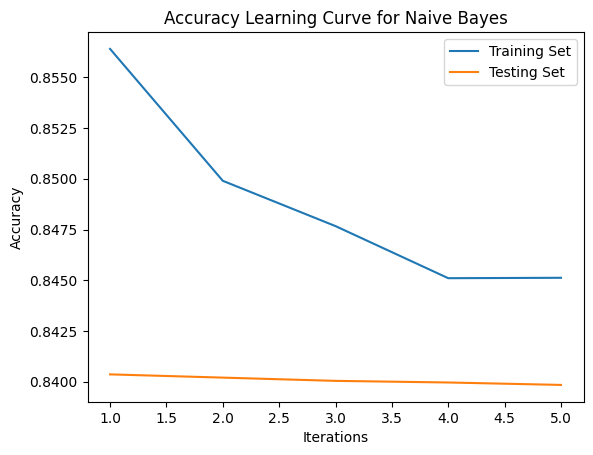

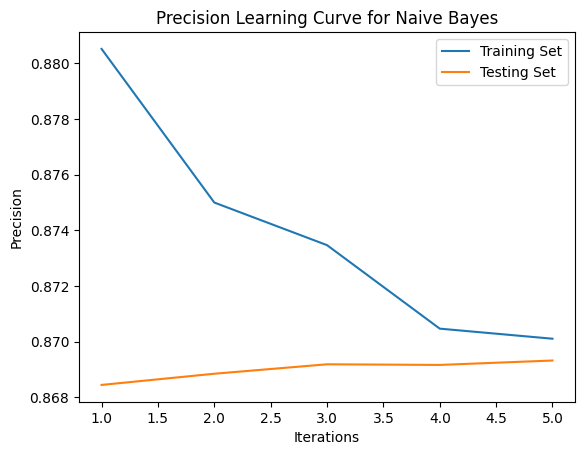

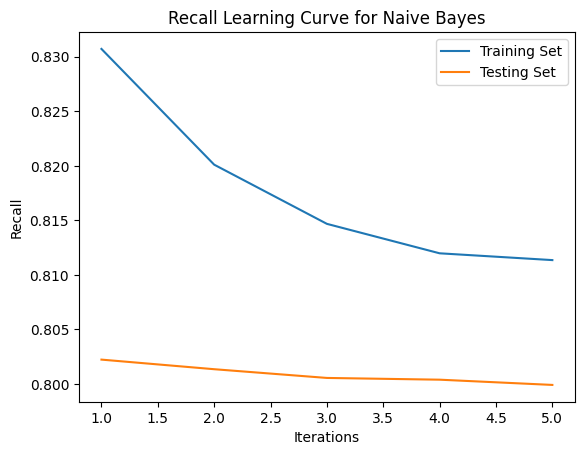

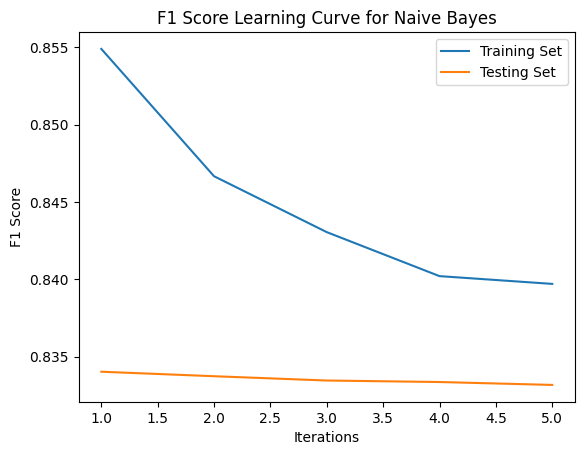

In [49]:
# Usage example for Naive Bayes
nbc = NaiveBayesCustom()
(
    training_accuracy_list, testing_accuracy_list,
    training_precision_list, testing_precision_list,
    training_recall_list, testing_recall_list,
    training_f1_list, testing_f1_list
) = learning_curves(nbc, x_train_binary, y_train, x_test_binary, y_test, n_splits=5)


                        # 2. Scikit-Learn

In [50]:
from sklearn.naive_bayes import GaussianNB

nb = GaussianNB()
nb.fit(x_train_binary, y_train)
print(classification_report(y_train, nb.predict(x_train_binary),
                            zero_division=1))
print(classification_report(y_test, nb.predict(x_test_binary),
                            zero_division=1))


              precision    recall  f1-score   support

           0       0.83      0.85      0.84     12500
           1       0.85      0.82      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000

              precision    recall  f1-score   support

           0       0.81      0.84      0.82     12500
           1       0.84      0.80      0.82     12500

    accuracy                           0.82     25000
   macro avg       0.82      0.82      0.82     25000
weighted avg       0.82      0.82      0.82     25000



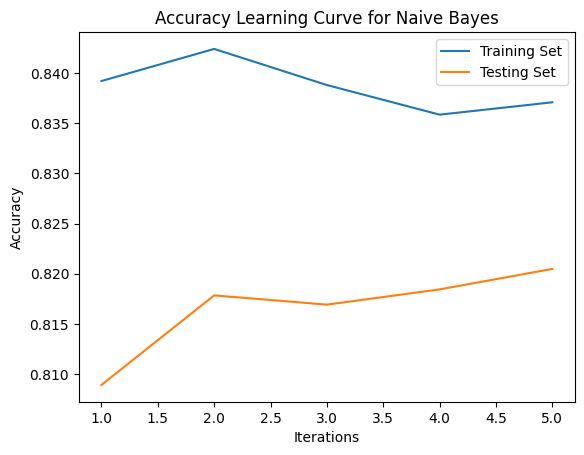

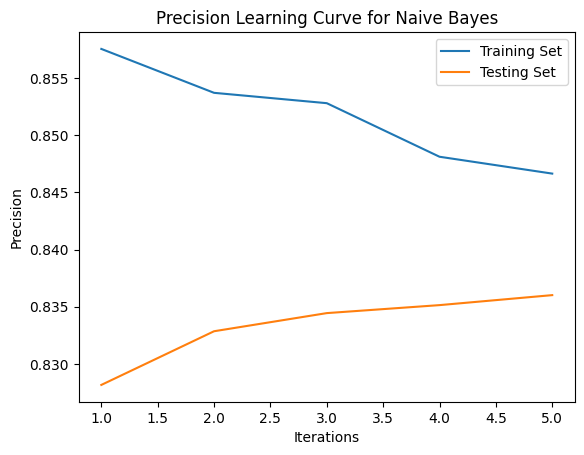

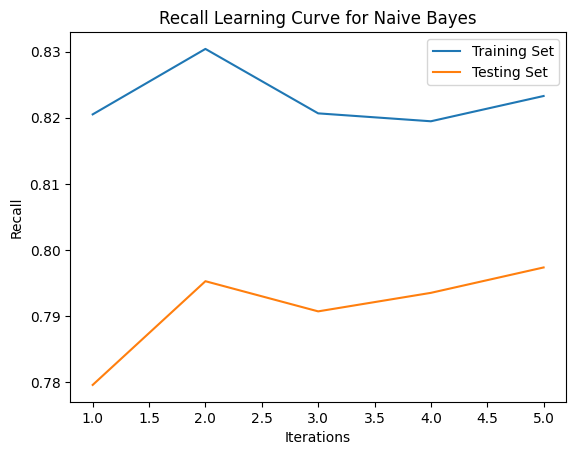

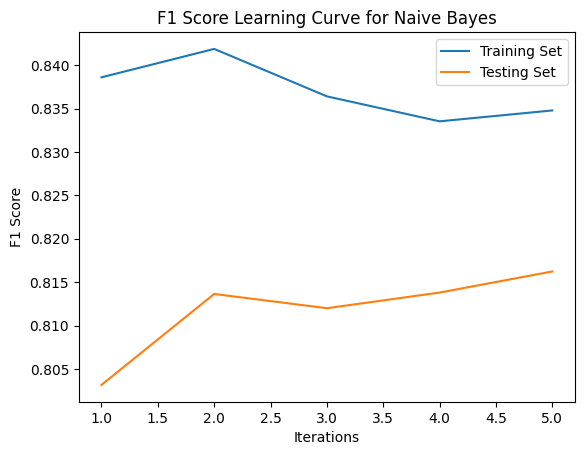

In [51]:
# Use learning_curves function for GaussianNB
nb_learning_curves = GaussianNB()
(
    nb_training_accuracy_list, nb_testing_accuracy_list,
    nb_training_precision_list, nb_testing_precision_list,
    nb_training_recall_list, nb_testing_recall_list,
    nb_training_f1_list, nb_testing_f1_list
) = learning_curves(nb_learning_curves, x_train_binary, y_train, x_test_binary, y_test, n_splits=5)


            #  Different Implementation of Learning_curves

In [52]:
def learning_curve2(predictor, x_train, y_train, x_test, y_test, n_splits):
  

  def append(scores): 
    y_pred_train = pred.predict(curr_x_train_part)        # validation data is excluded, only training data considered
    y_pred_test = pred.predict(x_test)

    for f in scores:
      f[1].append(f[0](curr_y_train_part, y_pred_train))  # validation data is excluded, only training data considered
      f[2].append(f[0](y_test, y_pred_test))

    splits.append(len(curr_x_train_part))
    

  def plotter(scores):
    fig, axs = plt.subplots(4, 2, figsize=(10, 17))      

    i = pred.__str__().find("(")
    suptitle = pred.__str__()[:i]
    fig.suptitle(suptitle, size="25")

    subplots = [ax for ax in axs.flat]
    for i in range(0, len(subplots), 2):
        f = scores[i//2]

        subplot = subplots[i]       # 1st subplot of metric f, zoomed in
        l1 = subplot.plot(splits, f[1], 'o-', color="royalblue", label="Training")
        l2 = subplot.plot(splits, f[2], '-', color="crimson", label="Testing")
        subplot.grid()
        subplot.set_xticks(splits, splits)
        subplot.set_title(f[0].__name__.replace("_", " ").capitalize(), loc='left', style='italic', bbox = dict(facecolor = 'white', boxstyle="round"))

        subplot = subplots[i+1]     # 2nd subplot of metric f, zoomed out  (specified range of y axis)
        l1 = subplot.plot(splits, f[1], 'o-', color="royalblue", label="Training")
        l2 = subplot.plot(splits, f[2], '-', color="crimson", label="Testing")
        subplot.grid()
        subplot.set_xticks(splits, splits)
        subplot.set_ylim(0, 1)
  
    fig.legend([l1, l2], labels=["Training", "Testing"],loc="upper right")
    fig.supxlabel("Training Set Size")
    fig.supylabel("Metrics score")
    plt.subplots_adjust(right=0.9)
    plt.show()



  pred = predictor

  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)

  splits = list()
  train_accuracy, test_accuracy = list(), list()
  train_precision, test_presicion = list(), list()
  train_recall, test_recall = list(), list()
  train_f1, test_f1 = list(), list()

  scores = [(accuracy_score,train_accuracy, test_accuracy), 
      (precision_score, train_precision, test_presicion),
      (recall_score, train_recall, test_recall),
      (f1_score, train_f1, test_f1)
    ]

  curr_x = x_splits[0]
  curr_y = y_splits[0]

  if type(predictor) is CustomLogisticRegression:             # the only classifier to be using validation data is our CustomLogisticRegression (early stopping), 
    curr_x_train_part, curr_y_train_part = pred.fit(curr_x, curr_y) # so in this case only the part of data actually used as training data should be considered as "training data"
  else:
    pred.fit(curr_x, curr_y)
    curr_x_train_part = curr_x
    curr_y_train_part = curr_y

  append(scores)  #predict then append

  for i in tqdm(range(1, len(x_splits))):

    pred = predictor

    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)

    if type(predictor) is CustomLogisticRegression:             # the only classifier to be using validation data is our CustomLogisticRegression (early stopping), 
      curr_x_train_part, curr_y_train_part = pred.fit(curr_x, curr_y) # so in this case only the part of data actually used as training data should be considered as "training data"
    else:
      curr_x_train_part = curr_x
      curr_y_train_part = curr_y
      pred.fit(curr_x, curr_y)
      

    append(scores) #predict then append
  
  # Show reporting table
  report_table = pd.DataFrame([x/len(x_train)*100 for x in splits], columns= ["Train Size (%)"]).set_index("Train Size (%)")
  report_table['Accuracy Train'] = train_accuracy
  report_table['Accuracy Test'] = test_accuracy
  report_table['Precision Train'] = train_precision
  report_table['Precision Test'] = test_presicion
  report_table['Recall Train'] = train_recall
  report_table['Recall Test'] = test_recall
  report_table['F1 Train'] = train_f1
  report_table['F1 Test'] = test_f1
  display(report_table)

  # Show reporting plots
  plotter(scores)
  return report_table


def loss_plot(history):
    kind = "loss"

    train = history.history[kind]
    val = history.history['val_' + kind]
    
    epochs = range(1, len(train)+1)
    plt.figure(figsize=(12,9))
    plt.plot(epochs, train, 'royalblue', label='Training ' + kind)
    plt.plot(epochs, val, 'orange', label='Validation ' + kind)
    plt.title('Training and validation ' + kind) 
    plt.xlabel('Epochs')
    plt.ylabel(kind)
    plt.legend()
    plt.show()

def make_comparisons(df_predictor1, df_predictor2):
    df_diffs = df_predictor1 - df_predictor2.values
    df_diffs = df_diffs.T
    sns.heatmap(df_diffs, annot=True, cmap=sns.cubehelix_palette(as_cmap=True), vmin=0, vmax=0.1, fmt=".3f")

100%|██████████| 4/4 [00:06<00:00,  1.54s/it]


,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
Train Size (%),,,,,,,,
20.0,0.856,0.84,0.881,0.868,0.831,0.802,0.855,0.834
40.0,0.850,0.84,0.875,0.869,0.820,0.801,0.847,0.834
60.0,0.848,0.84,0.873,0.869,0.815,0.801,0.843,0.833
80.0,0.845,0.84,0.870,0.869,0.812,0.800,0.840,0.833
100.0,0.845,0.84,0.870,0.869,0.811,0.800,0.840,0.833


C:\Users\Gwgw\AppData\Local\Temp\ipykernel_31176\1158605550.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=["Training", "Testing"],loc="upper right")


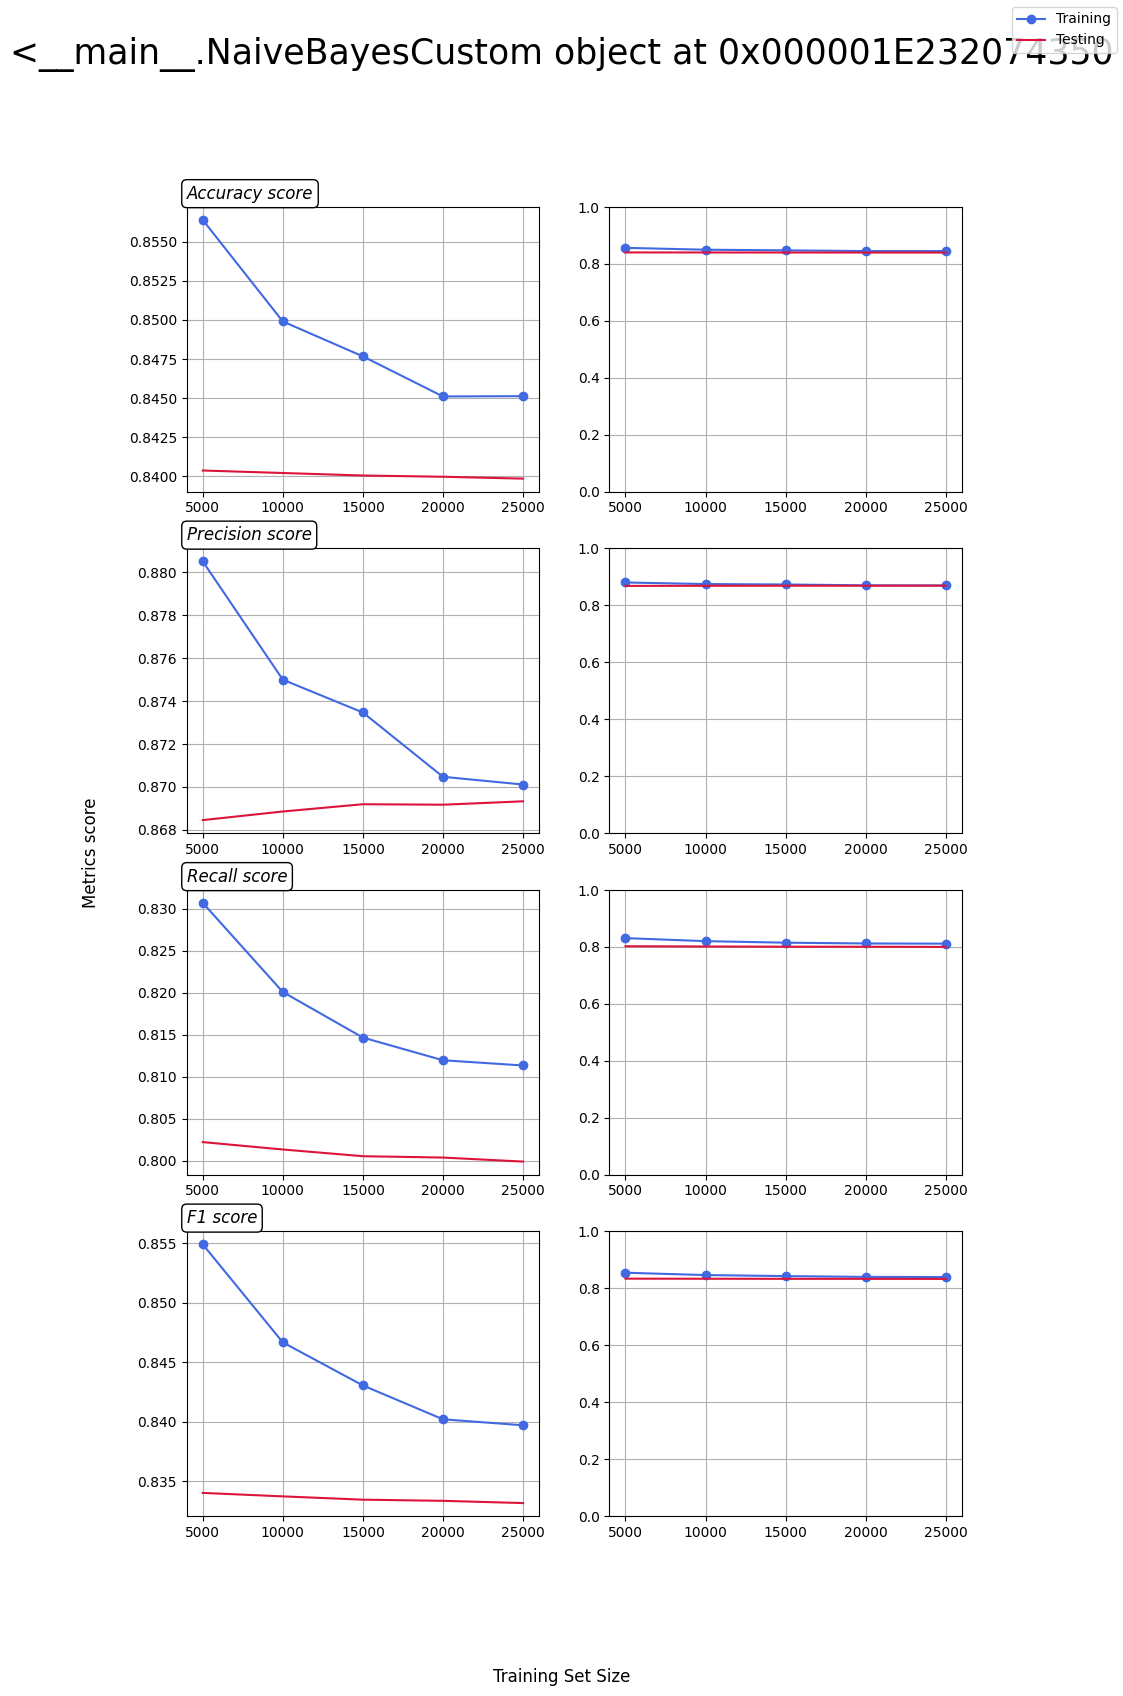

In [66]:
# Curves of Naive Bayes Classifier
nbc = NaiveBayesCustom()
nbc = learning_curve2(nbc, x_train_binary, y_train, x_test_binary, y_test, n_splits=5)

              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12500
           1       0.85      0.86      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



100%|██████████| 4/4 [00:03<00:00,  1.14it/s]


,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
Train Size (%),,,,,,,,
20.0,0.870,0.855,0.867,0.852,0.880,0.860,0.874,0.856
40.0,0.868,0.854,0.858,0.847,0.884,0.863,0.871,0.855
60.0,0.864,0.854,0.855,0.849,0.879,0.863,0.867,0.856
80.0,0.864,0.856,0.855,0.851,0.877,0.862,0.866,0.857
100.0,0.862,0.855,0.850,0.848,0.878,0.864,0.864,0.856


C:\Users\Gwgw\AppData\Local\Temp\ipykernel_31176\1158605550.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=["Training", "Testing"],loc="upper right")


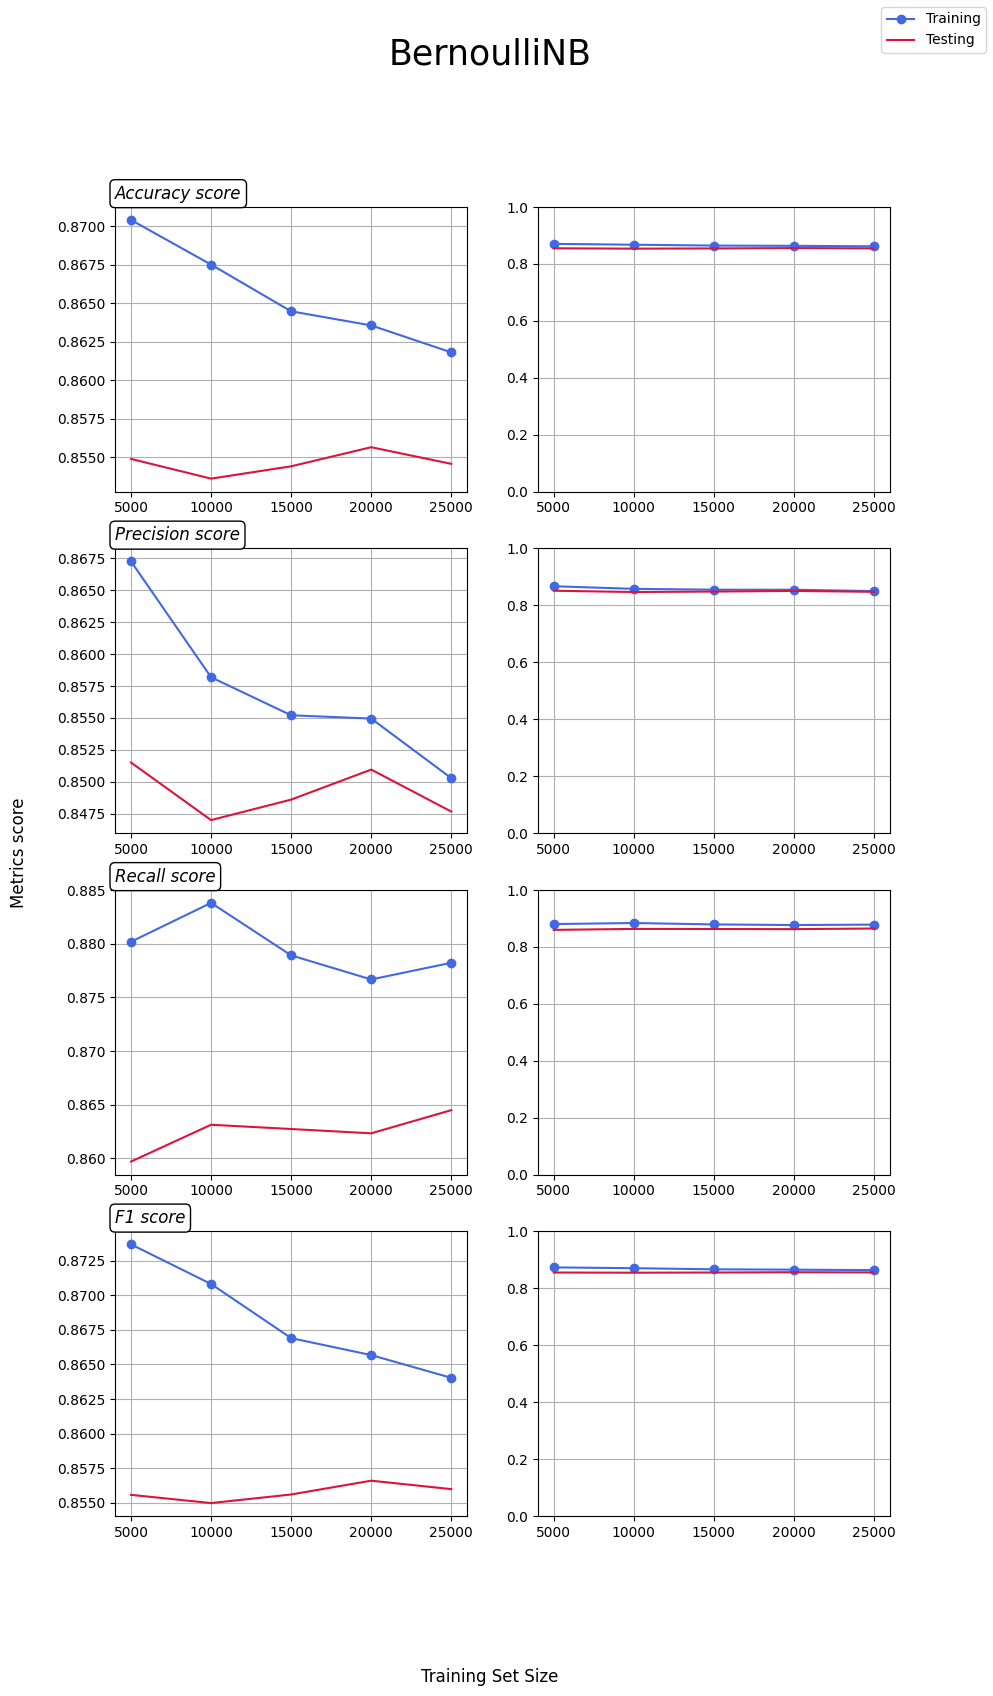

In [67]:
# Training Naive Bayes Classifier
nb_scikit = BernoulliNB()
nb_scikit.fit(x_train_binary, y_train)

# Using Naive Bayes Classifier
y_scikit = nb_scikit.predict(x_test_binary)
print(classification_report(y_test, y_scikit))


# Curves of Naive Bayes Classifier
nb_scikit = BernoulliNB()
report_BernoulliNB = learning_curve2(predictor=nb_scikit, x_train=x_train_binary, y_train=y_train, x_test=x_test_binary, y_test=y_test, n_splits=5)

                        # 2. Scikit-Learn

# Logistic Regression

In [68]:
class CustomLogisticRegression():
    def __init__(self, regularizator, learning_rate, n_iterations):
        self.regularizator = regularizator
        self.learing_rate = learning_rate
        self.num_iterations = n_iterations
        self.weights = None

    def sigmoid(self, t):
        return 1 / (1 + np.exp(-t))
    
    def fit(self,x_train_binary, y_train):
        """
        to stop the while loop, we need to calculate the s. this is the accuracy score. 
        to do so, we need to split our data into trainig and testing so every time 
        we can check the accuracy score.

        epoch : while the accuracy score is not acceptable, start a new epoch iterating again
                all the examples  (_x_train)
        """
        _x_train, _x_valuation, _y_train, _y_valuation = train_test_split(x_train_binary, y_train, test_size=0.2)
        
        num_of_features = _x_train.shape[1]
        num_of_examples = len(_y_train)

        """ 
            w0*x0 -> x0 = 1 (bias term)                                                                        # or  _x_train = np.insert(_x_train, 0, np.ones(num_of_examples), axis =1)
            Concatenate a column of ones to the left side of the entire array
        """
        _x_train = np.c_[np.ones(num_of_examples), _x_train]
        best_s=0

        # step 1 : start with random weights
        self.weights = np.random.rand(1, num_of_features+1) # num_of_features+1 beacuse we have the w0 (bias term)

        iteration = 1 # epoch
        unchanged_epochs = 0
        best_iteration = 0
        s = 0
        while ( iteration<=self.num_iterations ):
            # step 2 :  
            #---------------SHUFFLE-------------
            # Create a permutation index
            permutation_index = np.random.permutation(len(_y_train))
            # Use the permutation index to shuffle both arrays
            shuffled_y_train = _y_train[permutation_index]
            shuffled_x_train_binary = _x_train[permutation_index]
            #---------------END SHUFFLE-------------

            # maximizing l(w) 
            for i in range (num_of_examples):
                # step 3: calculating li(w) for every example
                """ 
                The np.dot function is used for matrix multiplication or dot product 
                between arrays. It calculates the sum of the element-wise products
                of two arrays.
                """
                t = np.dot(self.weights, shuffled_x_train_binary[i]) # t = w*x
                p_c_positive = self.sigmoid(t) # P(c+|xi)

                l = (shuffled_y_train[i]-p_c_positive)*shuffled_x_train_binary[i] # (yi - P(c+|xi)) * xi
              
                #step 5: inform weights
                self.weights =(1-2*self.learing_rate*self.regularizator) * self.weights + self.learing_rate * l       
                # step 6: move to next example 

            

            # checkig the accuracy 
            #step 7 :
            s = accuracy_score(_y_valuation, self.predict(_x_valuation))
            if s > best_s:
                #best_iteration = iteration 
                best_s = s
                best_weights = self.weights
                unchanged_epochs = 0
            else:
                iteration += 1 # increasing number of epoch
                unchanged_epochs +=1

            if unchanged_epochs == 33: # ανεχομαστε μεχρι 33 εποχες χωρις να εχουν βελτιωωθει γιατι μπορει να βελτιωθει η ακριβεια μετα απο καποιες εποχες. Αν οχι, επιστρεφουμε την καλυτερη
                self.weights = best_weights
                break
            
            # iteration += 1 #increasing number of epochs

    def predict(self, x_test_binary):
        num_of_examples = x_test_binary.shape[0]
        x_test = np.c_[np.ones(num_of_examples), x_test_binary]     #insert 1 for w0

        y_pred = list()
        for example in x_test:
            sign = np.dot(self.weights, example)
            # apofasi katataksis diafaneia 4 lecture 18
            if sign > 0 : 
                y_pred.append(1)
            else:
                y_pred.append(0)

        return np.array(y_pred)


                        # 2. Scikit-Learn

In [73]:
def find_regularizer(_x_train, _x_val, _y_train, _y_val):
    # reg should be in range (0,1)
    best_classifier = None
    best_acc = 0
    best_reg = 0
    
    n_iters_unchanged = 1
    # to kalytero βγαινει 0 σαν ρεγ αλλα 
    # ΝΑ ΑΛΛΑΞΕΙ ΣΕ WHILE ΜΕ 0.01000000000000000.1
    regularizer = 0
    while regularizer <= 100 :
        clr = CustomLogisticRegression( regularizer, 0.001, 100)
        clr.fit(_x_train, _y_train)
        _y_pred_val = clr.predict(_x_val)                 
        acc = accuracy_score(_y_val, _y_pred_val)
        print("\tRegularizer: ", regularizer, "\tDevalopment Accuracy Score: ", acc)
        if acc > best_acc:
            best_acc = acc
            best_regularizer = regularizer
            best_classifier = clr
            n_iters_unchanged = 0
        else:
            n_iters_unchanged += 1

        if n_iters_unchanged == 5:
            break
        regularizer += 0.0000000000000001 
        
    return best_classifier, best_regularizer, best_acc
    
    # for regularizer in range(0, 100):
    #     regularizer = regularizer / 100 + 1e-15 #δεν μπορει η παιθον να κανει βημα μη-ακεραιο και εδω γινεται η διαιρεση για να γινει καστ το reg σε range(0,1)
    #     lr = CustomLogisticRegression( learning_rate=0.001, regularizator=regularizer, n_iterations=100)
    #     lr.fit(x_train_binary=_x_train, y_train=_y_train)
    #     _y_pred_val = lr.predict(_x_val)                 

    #     acc = accuracy_score(_y_val, _y_pred_val)
    #     print("\tRegularizer: ", regularizer, "Accuracy on dev: ", acc)
    #     if acc > best_acc:
    #         best_acc = acc
    #         best_regularizer = regularizer
    #         best_classifier = lr
    #         n_iters_unchanged = 0
    #     else:
    #         n_iters_unchanged += 1

    #     if n_iters_unchanged == 5:
    #         break 
        
    # return best_classifier, best_regularizer, best_acc

# Training And Testing Logistic Regression

## custom logistic regression with sga

In [74]:
x_train_part, x_val_part, y_train_part, y_val_part = train_test_split(x_train_binary, y_train, test_size=0.1)

# Find best Logistic Regression Classifier (best λ factor of regularization)
best_classifier, best_regularizer, best_acc = find_regularizer(x_train_part, x_val_part, y_train_part, y_val_part)
print('Best validation data accuracy:\t', best_acc)
print('Best regularizer factor:\t', best_regularizer)

lr = best_classifier

# Using Logistic Regression Classifier
y = lr.predict(x_test_binary=x_test_binary)
print(classification_report(y_test, y))

	Regularizer:  0 Accuracy on dev:  0.8744
	Regularizer:  1e-16 Accuracy on dev:  0.8788
	Regularizer:  2e-16 Accuracy on dev:  0.8796
	Regularizer:  3e-16 Accuracy on dev:  0.8824
	Regularizer:  4e-16 Accuracy on dev:  0.8788
	Regularizer:  5e-16 Accuracy on dev:  0.8768
	Regularizer:  6.000000000000001e-16 Accuracy on dev:  0.8748
	Regularizer:  7.000000000000001e-16 Accuracy on dev:  0.8788
	Regularizer:  8.000000000000002e-16 Accuracy on dev:  0.8756
Best validation data accuracy: 0.8824
Best regularizer factor: 4e-16
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.86      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



In [70]:
#Algorithm to use in the optimization problem.
#Each solver tries to find the parameter weights that minimize a cost function
log_c = CustomLogisticRegression(3e-16, 0.001, 200)
log_c.fit(x_train_binary, y_train)
print(classification_report(y_test, log_c.predict(x_test_binary)))

              precision    recall  f1-score   support

           0       0.87      0.85      0.86     12500
           1       0.85      0.87      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



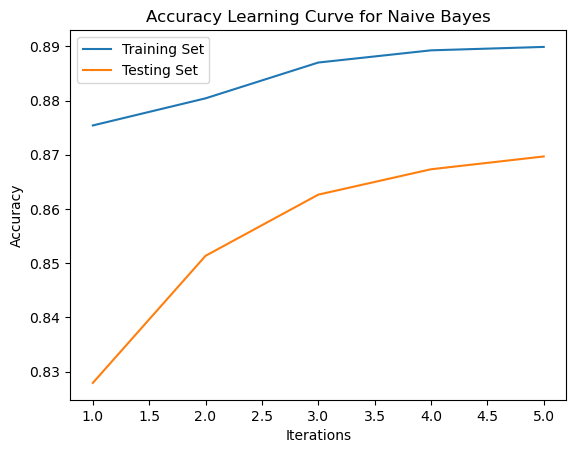

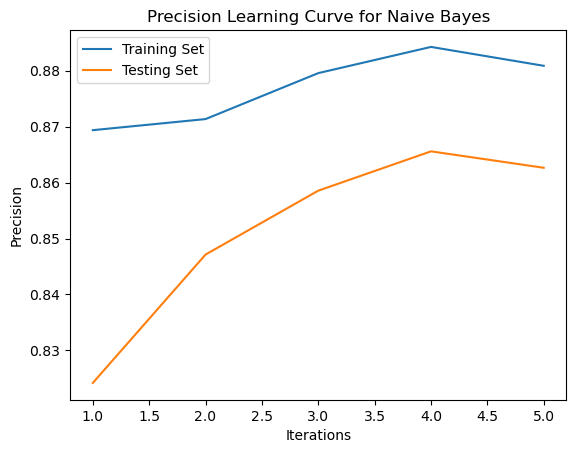

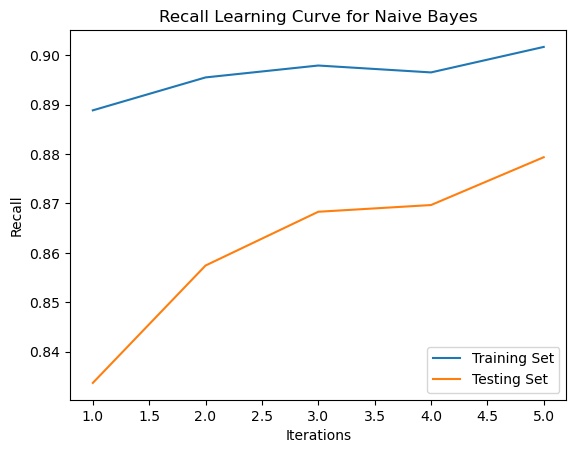

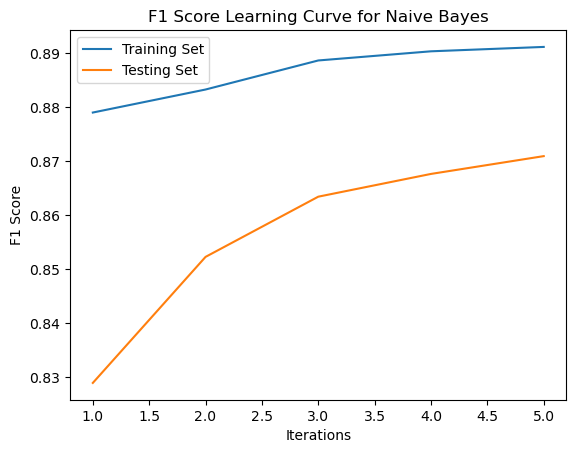

In [ ]:
# Usage example for Logistic Regression
# lr = CustomLogisticRegression(learning_rate=0.01, n_iterations=1000)
(
    training_accuracy_list, testing_accuracy_list,
    training_precision_list, testing_precision_list,
    training_recall_list, testing_recall_list,
    training_f1_list, testing_f1_list
) = learning_curves(lr, x_train_binary, y_train, x_test_binary, y_test, n_splits=5)


100%|██████████| 4/4 [00:33<00:00,  8.39s/it]


,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
Train Size (%),,,,,,,,
20.0,0.870,0.820,0.864,0.823,0.874,0.815,0.869,0.819
40.0,0.888,0.845,0.883,0.845,0.891,0.844,0.887,0.845
60.0,0.889,0.860,0.884,0.858,0.895,0.863,0.889,0.860
80.0,0.887,0.864,0.883,0.861,0.892,0.868,0.887,0.864
100.0,0.889,0.867,0.885,0.864,0.893,0.872,0.889,0.868


/var/folders/kg/v0vgjgtd33g0dx30qvvb8sqc0000gn/T/ipykernel_8425/1158605550.py:40: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend([l1, l2], labels=["Training", "Testing"],loc="upper right")


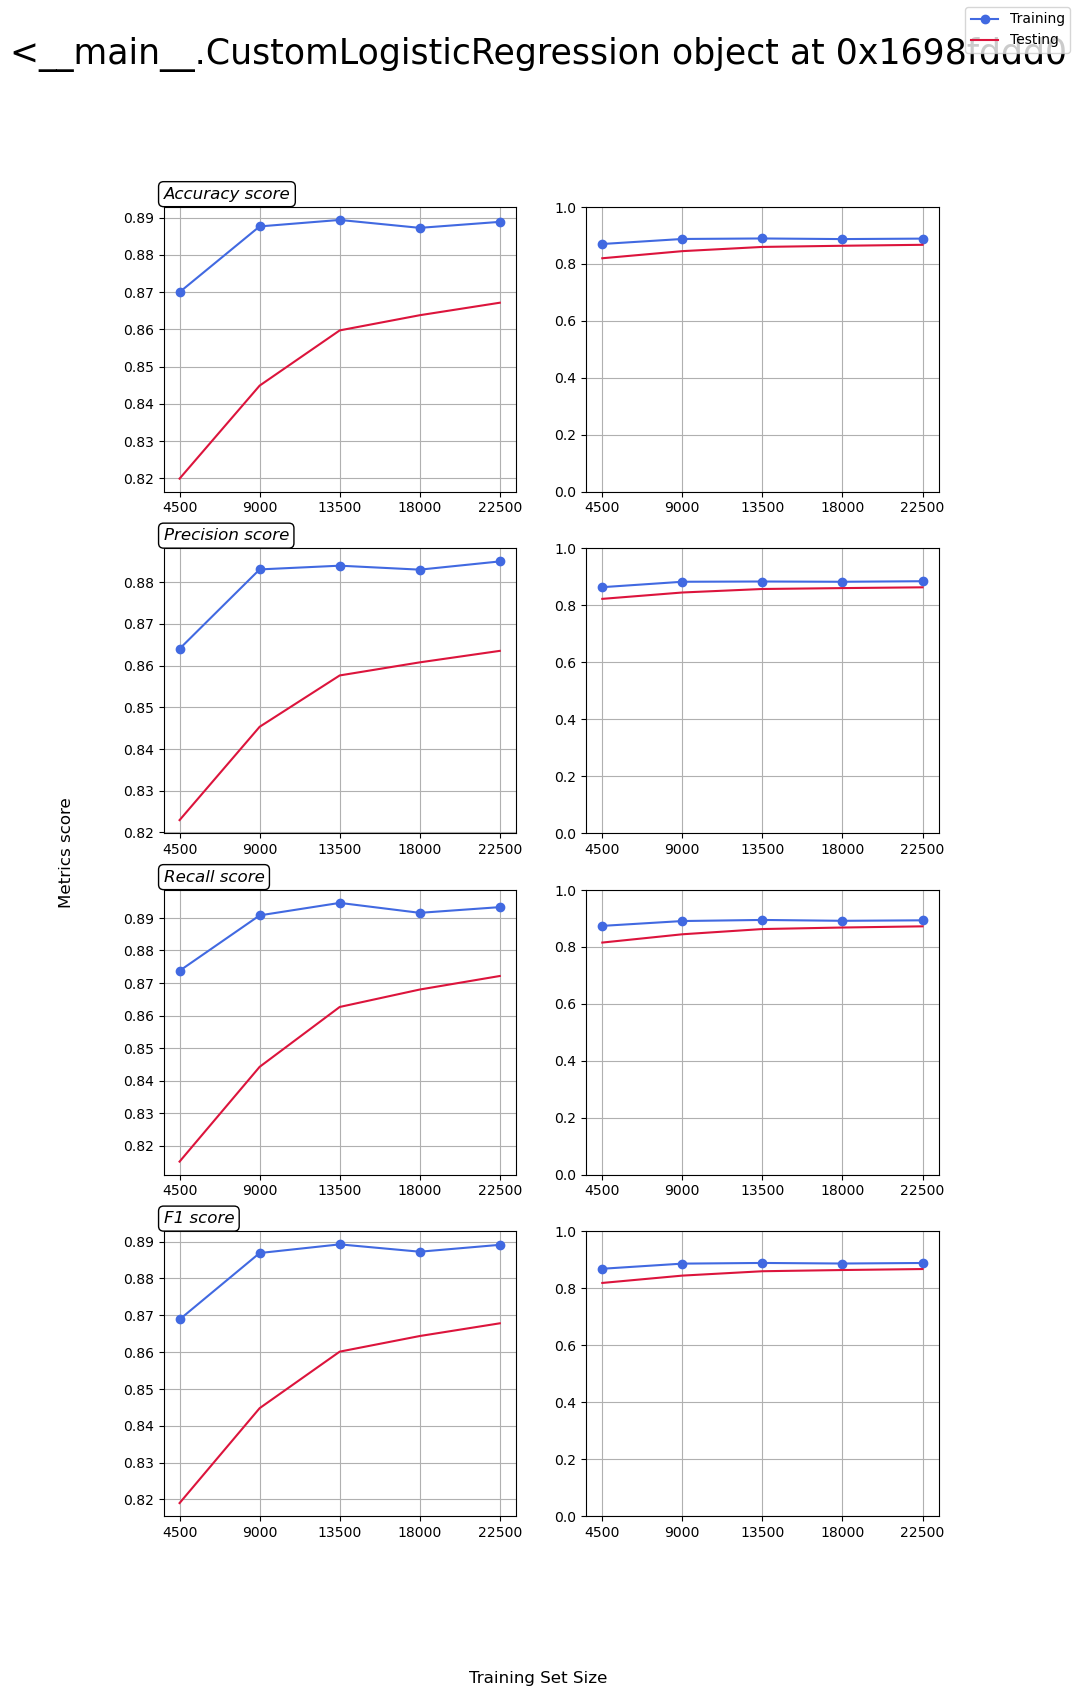

In [ ]:
# x_train_part, x_val_part, y_train_part, y_val_part = train_test_split(x_train_binary, y_train, test_size=0.1)

# # Find best Logistic Regression Classifier (best λ factor of regularization)
# best_classifier, best_regularizator, best_acc = find_best_regularizator(x_train_part=x_train_part, x_val_part=x_val_part, y_train_part=y_train_part, y_val_part=y_val_part)
# print('Best validation data accuracy:', best_acc)
# print('Best regularizator factor:', best_regularizator)

lr = best_classifier

# Curves of Logistic Regression Classifier
report_customLogisticRegression = learning_curve2(predictor=lr, x_train=x_train_part, y_train=y_train_part, x_test=x_test_binary, y_test=y_test, n_splits=5)

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.87      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



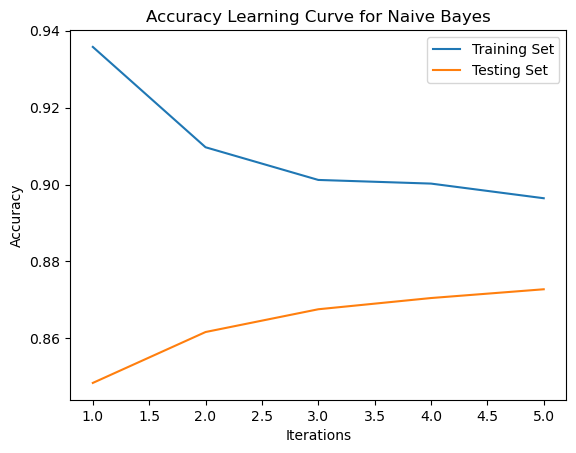

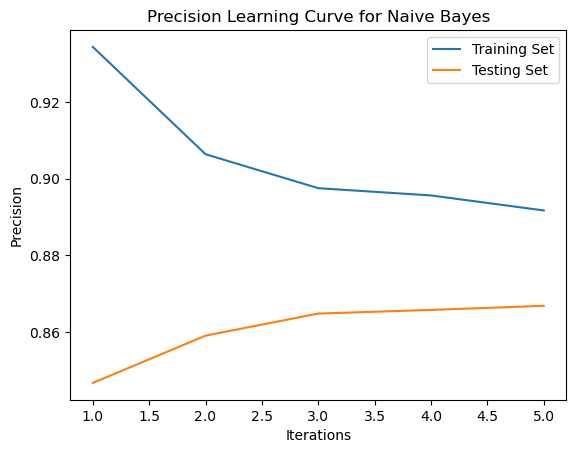

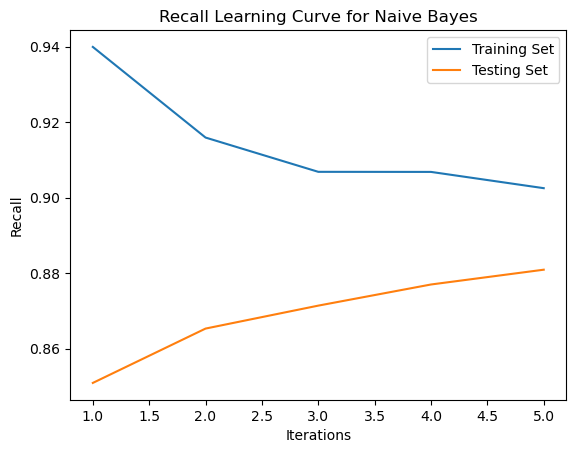

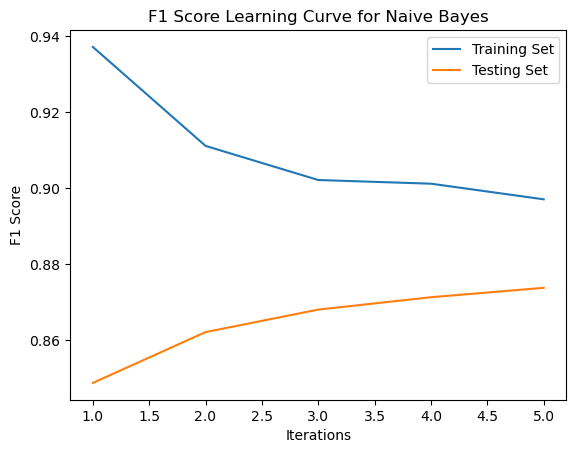

([0.9358, 0.9097, 0.9012, 0.90025, 0.89644],
 [0.8484, 0.86164, 0.86756, 0.87048, 0.87276],
 [0.9344006247559548,
  0.9063846455150802,
  0.8975167520693733,
  0.8956282000787712,
  0.8917081653624219],
 [0.8466804648941252,
  0.8590262886188548,
  0.8647876141325923,
  0.8657400094771758,
  0.8668031173738487],
 [0.9399057344854674,
  0.9158915495745102,
  0.9068100358422939,
  0.9067889542418502,
  0.90248],
 [0.85088, 0.86528, 0.87136, 0.87696, 0.88088],
 [0.9371450949676914,
  0.9111132985530072,
  0.9021394611727418,
  0.9011740228860159,
  0.897061747047831],
 [0.8487750379059932,
  0.862141803834044,
  0.8680613668061368,
  0.8713138860185995,
  0.8737848668809269])

In [ ]:
from sklearn.linear_model import LogisticRegression

#Algorithm to use in the optimization problem.
#Each solver tries to find the parameter weights that minimize a cost function
log = LogisticRegression()
log.fit(x_train_binary, y_train)

from sklearn.metrics import classification_report
print(classification_report(y_test, log.predict(x_test_binary)))

# # Use train_test_split to create training and validation sets
# x_train_part, x_val_part, y_train_part, y_val_part = train_test_split(x_train_binary, y_train, test_size=0.1)

# Initialize Logistic Regression Classifier
logistic_regression = LogisticRegression()

# Use learning_curvesLR function to plot learning curves
learning_curves(logistic_regression, x_train_binary, y_train, x_test_binary, y_test, n_splits=5)